# SPKIR CG data deep dive 1.6

In this notebook we display OOI SPKIR data stored in the kdata drive for certain deployments that may need additional annotations. Ref Des: GA01SUMO-RID16-08-SPKIRB000

In [18]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import norm
from scipy.signal import find_peaks, argrelmin

from ooi_data_explorations.common import list_methods, list_streams, get_annotations, add_annotation_qc_flags, load_kdata, get_vocabulary, update_dataset
from ooi_data_explorations.uncabled.process_spkir import spkir_datalogger
from ooinet.M2M import get_deployments
from qartod_testing.data_deep_dive import nanfill_time_gaps, check_chla_swr, compare_spkir_to_ctdbp

In [2]:
# Set parameters for data request 
refdes = 'GA01SUMO-RID16-08-SPKIRB000'
site, node, sensor = refdes.split('-', 2)

In [3]:
# Set parameter for SPKIR comparison with FLORT Chl-a estimate
flort_node = 'RID16'

In [4]:
# Set parameter for SPKIR internal temperature comparison with co-located CTDBP sea water temperature
ctdbp_node = 'RID16'
ctdbp_sensor = '03-CTDBPF000'

### Check data delivery methods, deployments, and annotations

In [5]:
# Create dict of methods and associated data streams
methods = list_methods(site, node, sensor)

streams = {}
for method in methods:
    streams[method] = list_streams(site, node, sensor, method)

streams

{'recovered_host': ['spkir_abj_dcl_instrument_recovered'],
 'telemetered': ['spkir_abj_dcl_instrument']}

In [6]:
# View deployment information
deployments = get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-SPKIRB-00230,2542,-42.92283,-42.4393,12.0,2015-03-15 21:25:00,2015-11-26 10:08:00,AT26-30,NBP1510
1,2,CGINS-SPKIRB-00299,1421,-42.9246,-42.58668,12.0,2015-11-14 21:06:00,2016-11-08 10:10:00,NBP1510,NBP1609
2,3,CGINS-SPKIRB-00230,2542,-42.9204,-42.440932,12.0,2016-10-27 01:47:00,2018-01-14 10:24:00,NBP1609,AT39-03


In [7]:
## View annotations
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)

if not annotations.empty:
    annotations = annotations.drop(columns=['@class'])
    annotations['beginDate'] = pd.to_datetime(annotations.beginDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')
    annotations['endDate'] = pd.to_datetime(annotations.endDT, unit='ms').dt.strftime('%Y-%m-%dT%H:%M:%S')

annotations
# annotations['annotation'][5]

# Note: now I have moved the lines that add a human-readable date time up here where the annotations are displayed, however I'm not sure if the begin and endDT columns still need 
# to exist. I would like to remove them because they are just taking up space and don't add anything to the dataFrame displayed below.

,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters,beginDate,endDate
0,653,GA01SUMO,None,None,None,None,1426454700000,1448532480000,Deployment 1: Buoy log files showed that seawa...,False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00
1,658,GA01SUMO,RID16,08-SPKIRB000,None,None,1426454700000,1448532480000,Deployment 1: The copper bio-shutter was missi...,False,lgarzio@marine.rutgers.edu,None,[],2015-03-15T21:25:00,2015-11-26T10:08:00


### Deployment 1

My initial thought was that we need an annotation for spotty data starting in June 2015 when input and analog rail voltages start varying more than normal. Although I didn't think it would be relevant at first, I will check how the internal temperature compares to a co-located temperature since it is a fast process now. Not sure how helpful this is, but we do see the offset in temperatures narrow as the instrument stops sampling. I should probably also note that there is about 3 more months of data from the CTDBP than from the SPKIR, so this SPKIR was likely slowly failing.

In [8]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 1

In [9]:
# Request annotations and load data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


In [10]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [11]:
spkir = nanfill_time_gaps(spkir)

In [12]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 8903, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-03-15T21:30:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 18.0 18.0 ... 12.0
    input_voltage                  (station, time) float32 8.49 8.49 ... 7.89
    deployment                     (station, time) float32 1.0 1.0 ... nan 1.0
    analog_rail_voltage            (station, time) float32 5.31 5.31 ... 5.25
    raw_irradiance_412             (station, time) float32 2.147e+09 ... 2.18...
    raw_irradiance_444             (station, time) float32 2.147e+09 ... 2.19...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 -0.005454 ... 0.2483
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... nan 0.0
    station_name                   (station) <U8 'GA01SUMO'
    lat                            (station) float32 -42.92
    lon                            (station) float32 -42.44
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

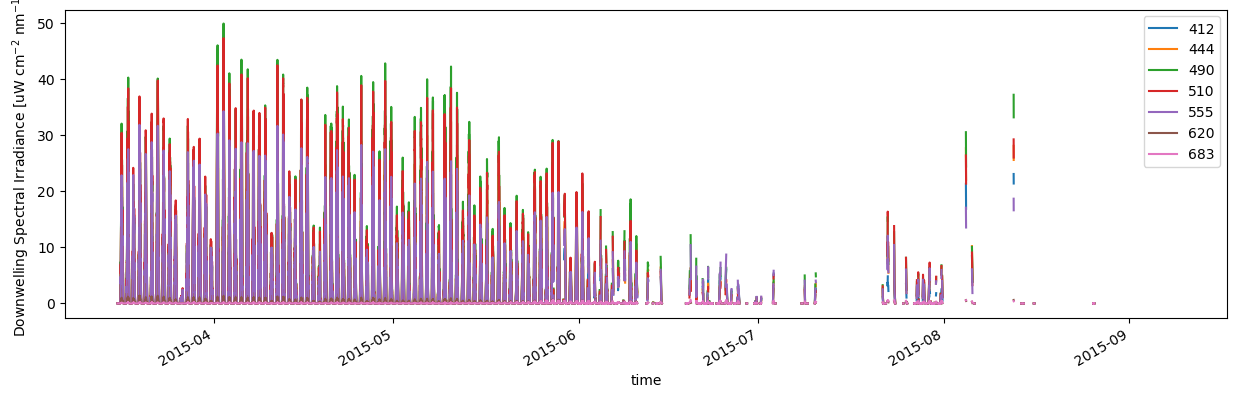

In [11]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

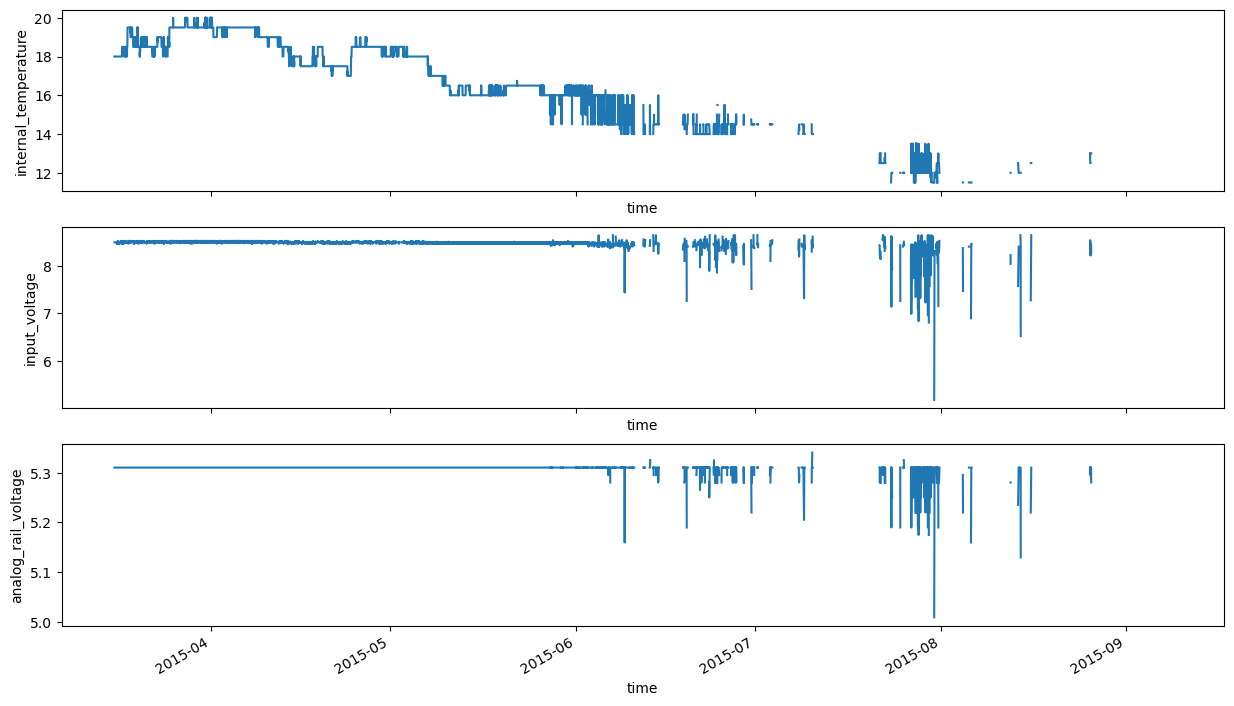

In [12]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


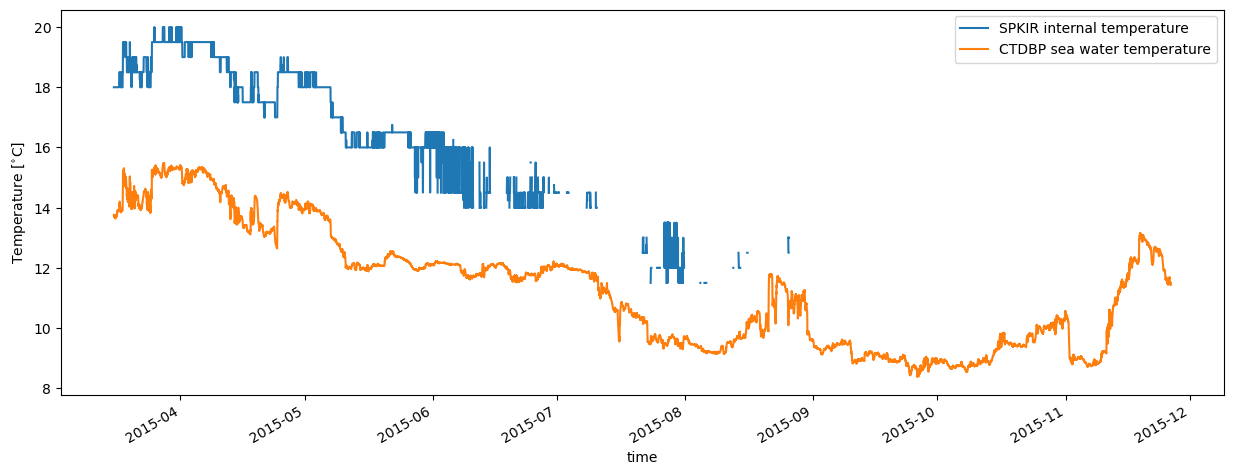

In [13]:
# Compare SPKIR internal temperature time series to sea water temperature
# to check that the instrument is performing as expected
ctdbp, fig, ax = compare_spkir_to_ctdbp(spkir, site, deploy, ctdbp_node, ctdbp_sensor)

<xarray.DataArray 'input_voltage' ()>
array(7.44, dtype=float32)
Coordinates:
    time     datetime64[ns] 2015-06-09T04:00:00
Attributes:
    ooinet_variable_name:  vin_sense
    coordinates:           time lon lat z
<xarray.DataArray 'time' ()>
array('2015-09-08T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2015-09-08T12:00:00


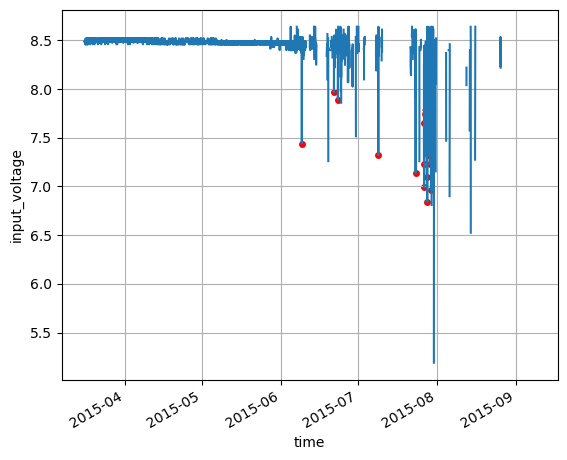

In [31]:
# Find start of low spikes in supply voltage as start date for annotation
# Use last data point for end date of annotation
volt_min = argrelmin(spkir.input_voltage.squeeze().data)
spkir.input_voltage.squeeze().plot()
spkir.input_voltage.squeeze().where(spkir.input_voltage<8)[volt_min].plot.scatter(c="r")
plt.grid()
print(spkir.input_voltage.squeeze()[volt_min].where(spkir.input_voltage.squeeze()[volt_min]<8, drop=True).sel(time="June 2015")[0])
print(spkir.downwelling_irradiance_555.time[-1])

### Deployment 2

Irradiance drops down below 10 uW/cm2/nm from June 2016 through rest of deployment. 

The Chl-a estimate shows how earlier in the deployment the downwelling spectral irradiance dropped to about half of its original value during the first large bloom. The SWR signal starts to climb again after June 2016, while the SPKIR signal remains near zero. There is not a sustained high Chl-a concentration estimate, while the SPKIR is measuring near-zero values. The spikes in Chl-a at the end of the deployment also coincide with SWR returning to its maximum magnitude, so I would expect the SPKIR to report much larger values if it was not biofouled or damaged in some way. June-early November 2016 data should be considered suspect. 

In [8]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 2

In [9]:
# load annotations and data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:08<00:00,  4.42s/it]


In [10]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [11]:
spkir = nanfill_time_gaps(spkir)

In [12]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

<xarray.Dataset>
Dimensions:                        (time: 33833, station: 1)
Coordinates:
  * time                           (time) datetime64[ns] 2015-11-14T21:15:00 ...
Dimensions without coordinates: station
Data variables: (12/23)
    internal_temperature           (station, time) float32 14.5 14.5 ... 12.5
    input_voltage                  (station, time) float32 8.34 8.34 ... 8.31
    deployment                     (station, time) float32 2.0 2.0 ... 2.0 2.0
    analog_rail_voltage            (station, time) float32 5.34 5.34 ... 5.34
    raw_irradiance_412             (station, time) float32 2.153e+09 ... 2.14...
    raw_irradiance_444             (station, time) float32 2.154e+09 ... 2.14...
    ...                             ...
    downwelling_irradiance_683     (station, time) float32 0.00429 ... 0.09303
    rollup_annotations_qc_results  (station, time) float32 0.0 0.0 ... 0.0 0.0
    station_name                   (station) <U8 'GA01SUMO'
    lat                            (station) float32 -42.92
    lon                            (station) float32 -42.59
    z                              (station) float32 12.0
Attributes: (12/69)
    node:                               RID16
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_host
    stream:                             spkir_abj_dcl_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    geospatial_vertical_min:            12.0
    geospatial_vertical_max:            12.0

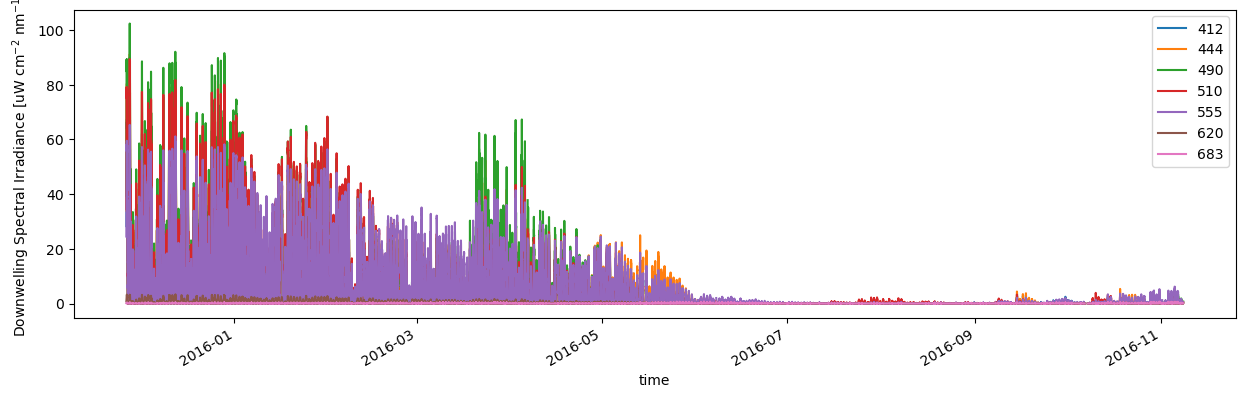

In [18]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

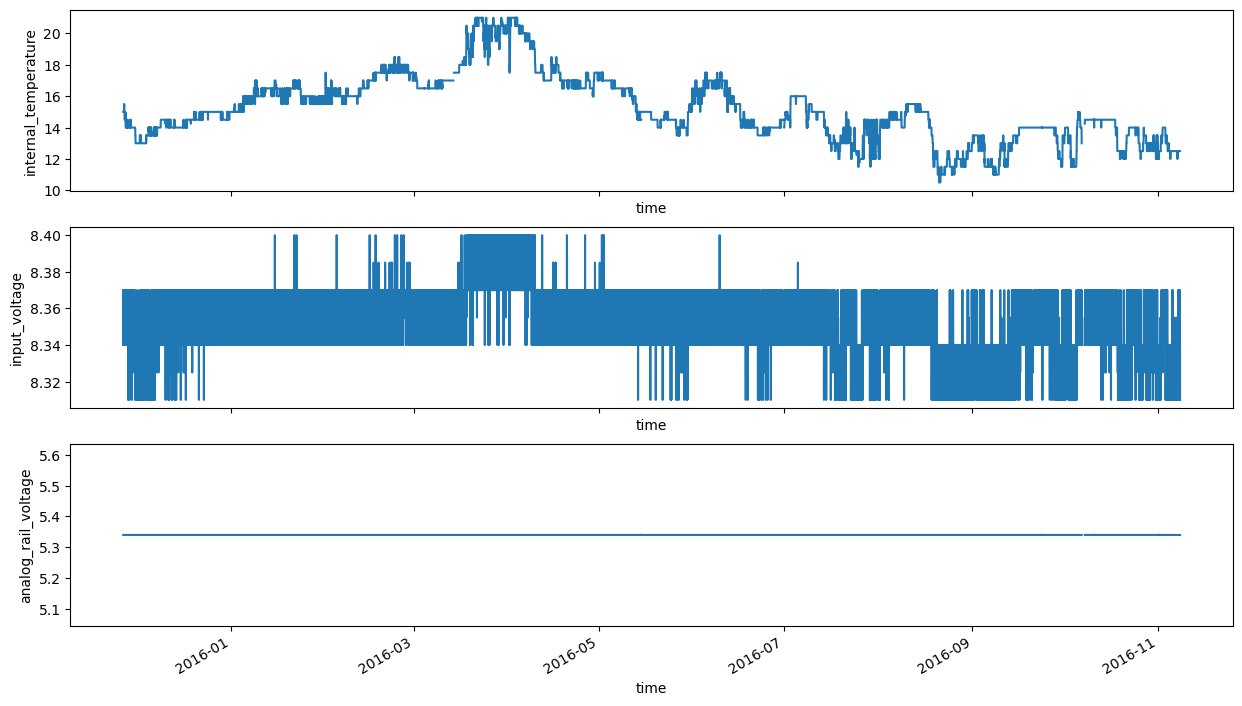

In [19]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


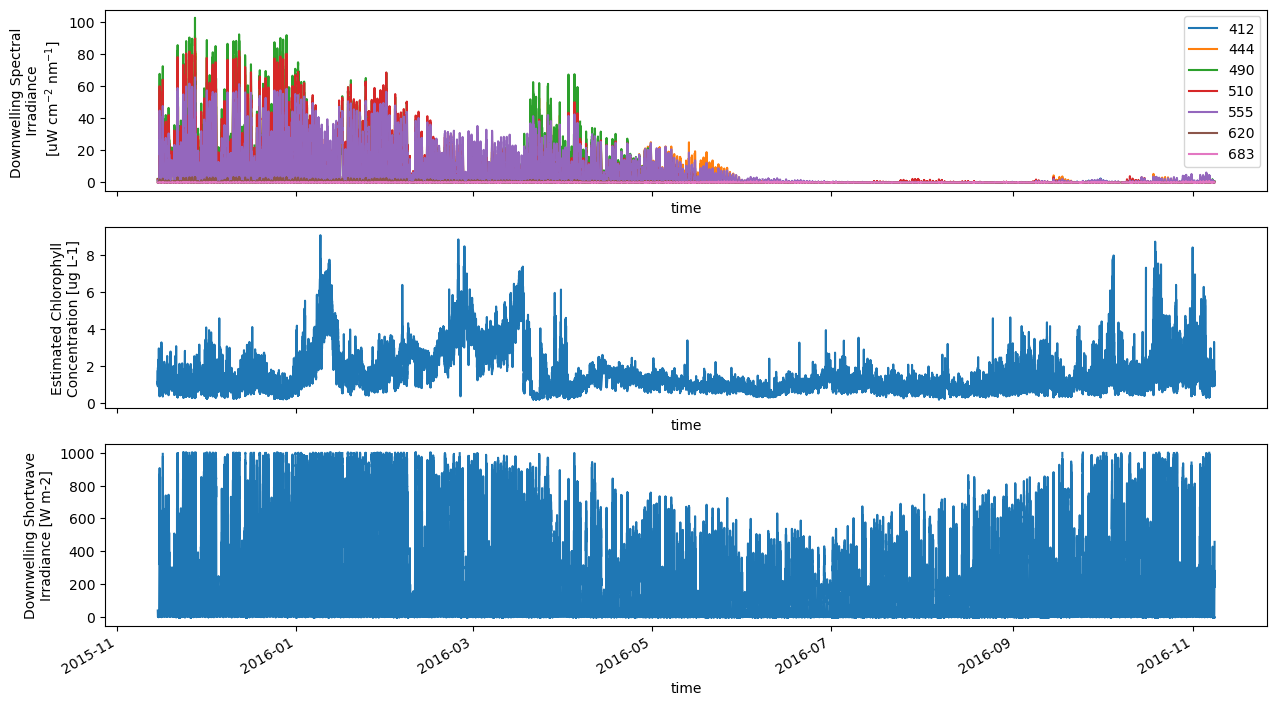

In [13]:
# Plot irradiance against SWR from the surface buoy METBK, co-located FLORT
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

In [26]:
# Look for last date where any downwelling irradiance value is above 5 uW/cm2/nm
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        if len(spkir[var].where(spkir[var]>7, drop=True))>0:
            print(f"{spkir[var].radiation_wavelength} nm SPKIR > 7 $\mu$W cm$^{-2}$ nm$^{-1}$ ends\
                  {spkir[var].where(spkir[var]>7, drop=True).time[-1].values}")
        else:
               pass
print(f"last day of deployment: {spkir['time'][-1].values}")

412 nm SPKIR > 7 $\mu$W cm$^-2$ nm$^-1$ ends                  2016-05-19T14:00:00.000000000
444 nm SPKIR > 7 $\mu$W cm$^-2$ nm$^-1$ ends                  2016-05-26T14:15:00.000000000
490 nm SPKIR > 7 $\mu$W cm$^-2$ nm$^-1$ ends                  2016-05-13T14:15:00.000000000
510 nm SPKIR > 7 $\mu$W cm$^-2$ nm$^-1$ ends                  2016-05-15T16:15:00.000000000
555 nm SPKIR > 7 $\mu$W cm$^-2$ nm$^-1$ ends                  2016-05-26T14:15:00.000000000
last day of deployment: 2016-11-08T09:15:00.000000000


### Deployment 3

Irradiance in Deployment 3 for channels with wavelengths shorter than 555 nm drops off after July 2017 for rest of deployment.

Unfortunately most of the FLORT data after July 2017 is missing, although we do have an estimate for relatively high Chl-a concentrations at the end of the deployment. The SWR signal climbs steadily to values similar to measurements at the start of the deployment, and it stays around that level from October 2017 through January 2018. Without the FLORT data, I cannot say with more confidence whether this SPKIR data came from a biofouled instrument.

I will try checking the Chl-a estimate from the FLORT on the surface buoy.

That might have helped some. The FLORT on the surface buoy is deployed at 1 m depth. The Chl-a estimate at this depth increases from the start of the deployment until June 2017 when it reaches its maximum. Aside from the diel vertical migration, the Chl-a concentration estimate stays at this maximum from June 2017 through the end of the deployment. This maximum is also 5 times greater than the maximum Chl-a estimate at the depth of the NSIF (12 m). Based on this estimate, (assuming these values aren't bogus) it's possible that the surface waters were saturated with plankton, and therefore the downwelling spectral irradiation was diminished by environmental factors. We probably don't need an annotation afterall.

I will add the caveat that the higher values above 30ug/L of estimated chlorophyll concentration all have a fail flag according to the older QC tests. Without a QARTOD test currently in production for the FLORT instrument class, I am considering these flags with caution. I suspect that either the gain for the surface buoy FLORT is off, or the FLORT is measuring concentrations at the upper limit of what the instrument can resolve. Even though there are lots of measurements below this cutoff for reasonable measurements, now I am not sure if we can say whether there actually was a lot of phytoplankton absorbing light in the water column above the SPKIR.

Checking the CTD for the end of the deployment wasn't helpful because the CTDBP data from the NSIF ended 2 months into the deployment.

In [8]:
# Set method and stream strings
method = methods[0]
stream = streams[method][0]
deploy = 3

In [9]:
# load annotations and data from the local kdata directory
annotations = get_annotations(site, node, sensor)
annotations = pd.DataFrame(annotations)
spkir = load_kdata(site, node, sensor, method, stream, ('*deployment%04d*SPKIR*.nc' % deploy))
spkir = spkir_datalogger(spkir, burst=True)

Loading and Processing Data Files: 100%|██████████| 2/2 [00:08<00:00,  4.22s/it]


In [10]:
# Add qc flags for annotations retrieved above
if not annotations.empty:
    # create an annotation-based quality flag
    spkir = add_annotation_qc_flags(spkir, annotations)

    # clean-up the data, removing values that were marked as fail either from the quality checks or in the
    # annotations
    spkir = spkir.where(spkir.rollup_annotations_qc_results < 4) # flags from annotations
    # spkir = spkir.where(spkir. # not sure which summary_qc variables are in here that I should use for this part -- there isn't such a variable in these datasets

In [13]:
spkir = nanfill_time_gaps(spkir)

In [14]:
# Check structure of edited data and contents
vocab = get_vocabulary(site, node, sensor)[0]
spkir = update_dataset(spkir, vocab['maxdepth'])
spkir['time'] = pd.to_datetime(spkir.time, unit='s')
spkir

ValueError: Dimension station already exists.

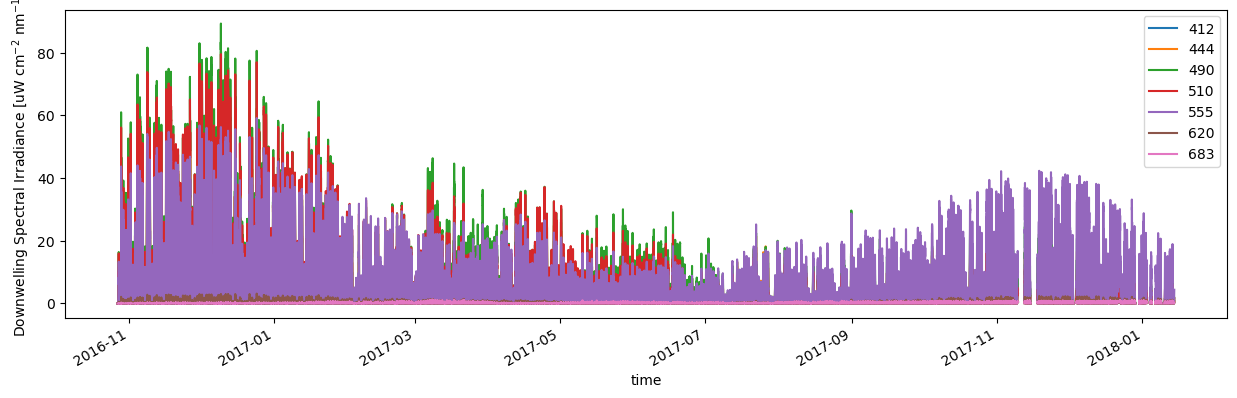

In [15]:
# First plot edited data to check whether inserting nans over gaps in time coverage is necessary
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

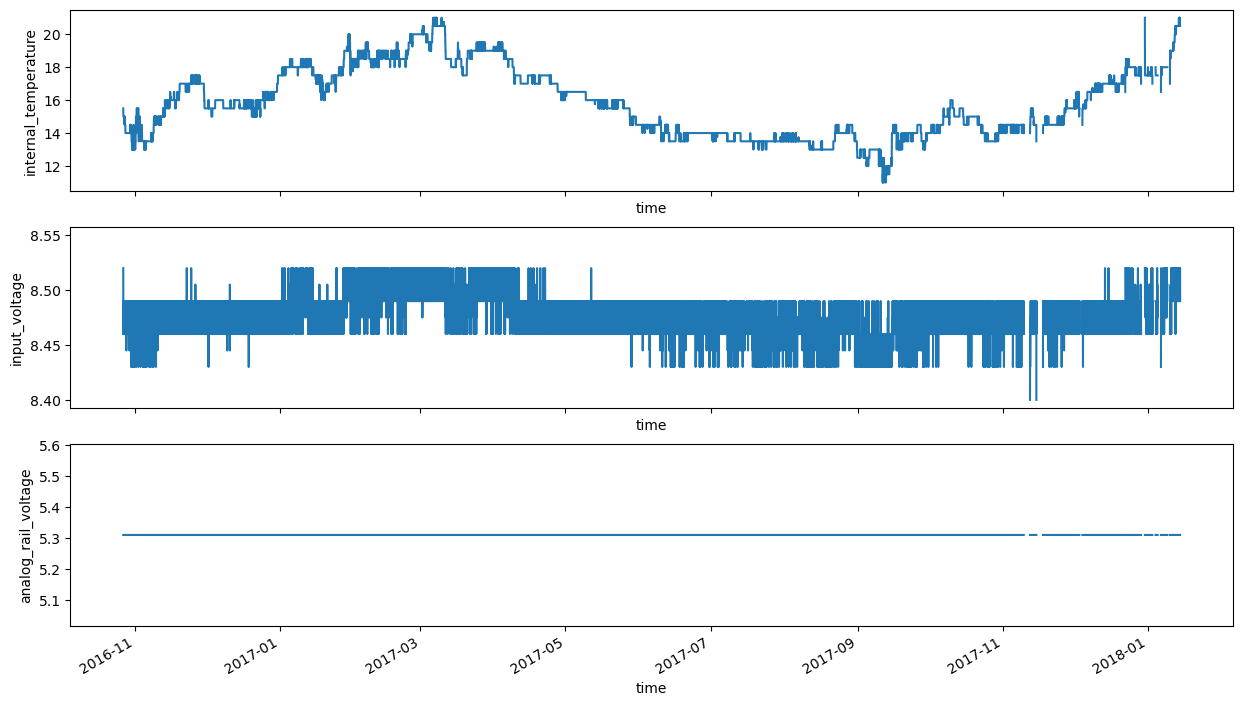

In [16]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].plot.line(ax=ax[0])
spkir.input_voltage[0].plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].plot.line(ax=ax[2])

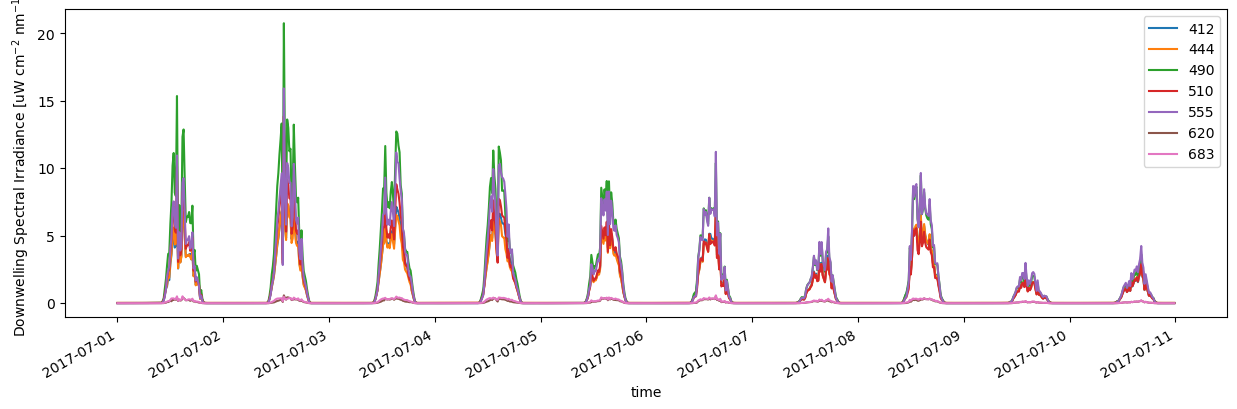

In [15]:
# plot a shorter time series 
fig, ax = plt.subplots(1,1,figsize=(15,4))
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        spkir[var].sel(time=slice('2017-07-01','2017-07-10')).plot(ax=ax, label=spkir[var].radiation_wavelength)
ax.set_ylabel('Downwelling Spectral Irradiance [uW cm$^{-2}$ nm$^{-1}$]')
plt.legend()

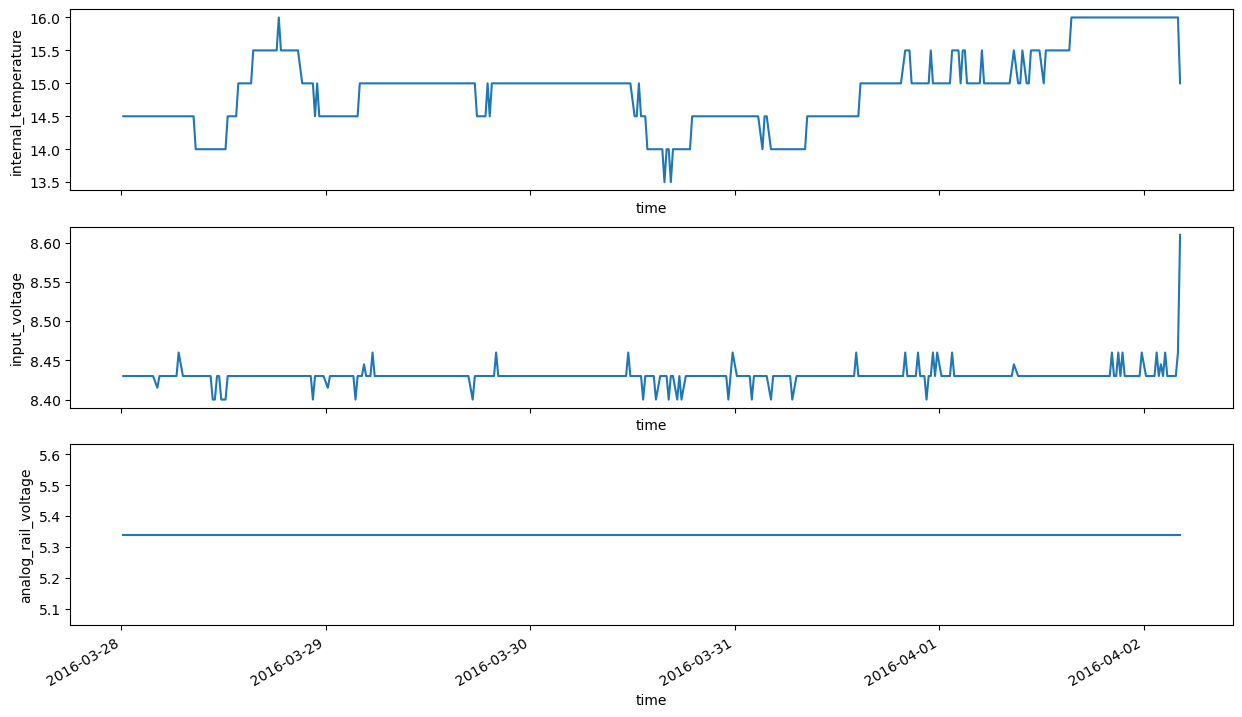

In [58]:
#  Checking internal temperature, supply voltage, and analog rail voltage during this time
fig, ax = plt.subplots(3,1, sharex=True, figsize=(15,8))
spkir.internal_temperature[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[0])
spkir.input_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[1])
spkir.analog_rail_voltage[0].sel(time=slice('2016-03-28','2016-04-04')).plot.line(ax=ax[2])

Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Loading and Processing Data Files: 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]


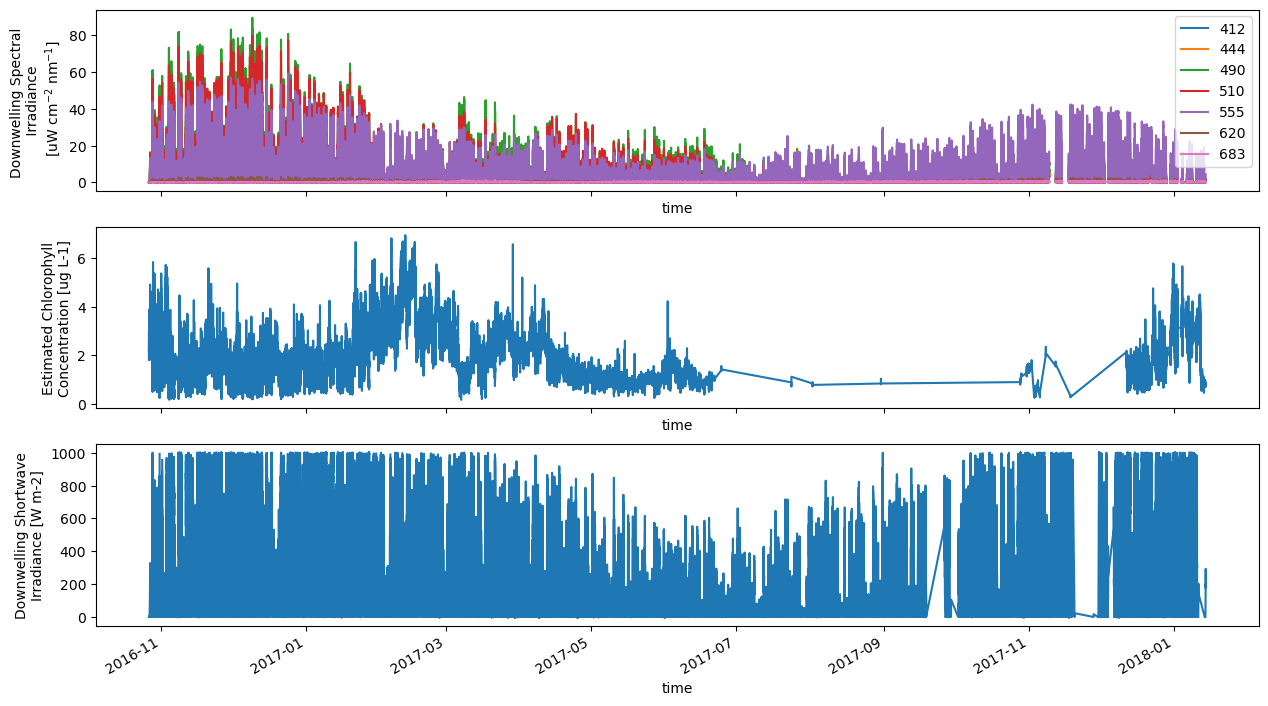

In [12]:
# Plot irradiance against SWR from the surface buoy METBK, co-located FLORT
metbk, flort, fig, ax = check_chla_swr(spkir, site, deploy, flort_node)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]


Loading and Processing Data Files: 100%|██████████| 2/2 [00:08<00:00,  4.49s/it]


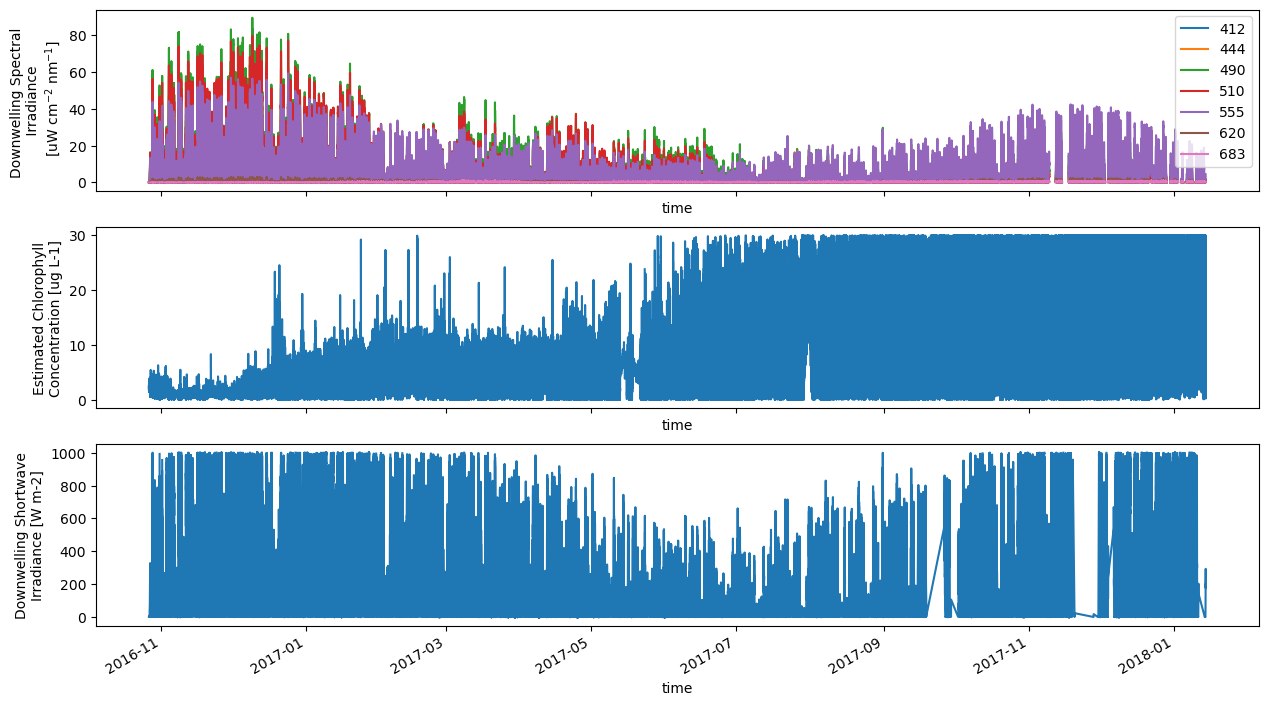

In [18]:
# Plot irradiance against SWR from the surface buoy METBK, surface buoy FLORT
metbk, flort_sbd, fig, ax = check_chla_swr(spkir, site, deploy, 'SBD12')

(array([6132521.,       0.,       0.,       0.,       0.,       0.,
          21366.,       0.,       0.,  128537.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

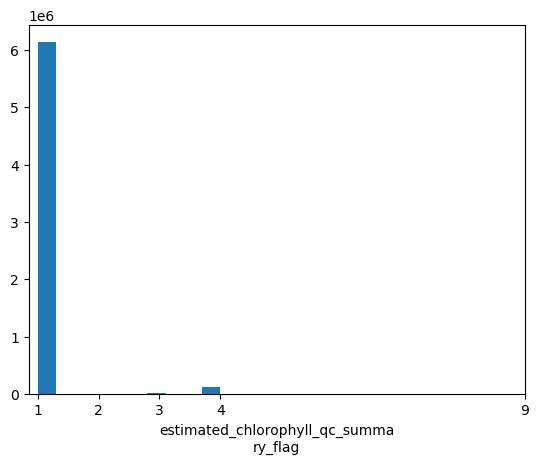

In [32]:
# Check reliability of surface buoy FLORT data. Unfortunately the available QC flags may be outdated.
flort_flag = flort_sbd['estimated_chlorophyll_qc_summary_flag']
flort_flag.plot.hist(xticks=[1, 2, 3, 4, 9])

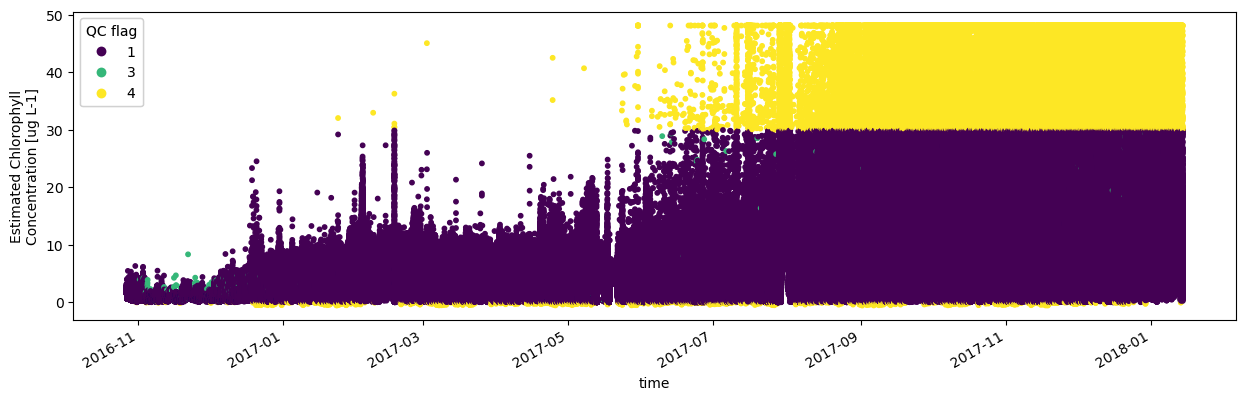

In [33]:
# Plot the estimated chlorophyll with color determined by flag
fig, ax = plt.subplots(1,1,figsize=(15,4))
scatter = flort_sbd['estimated_chlorophyll'].plot.scatter(ax=ax, s=10, c=flort_flag, cmap='Dark2', edgecolors=None)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="QC flag")
ax.add_artist(legend1)

Loading and Processing Data Files: 100%|██████████| 1/1 [00:00<00:00,  9.77it/s]


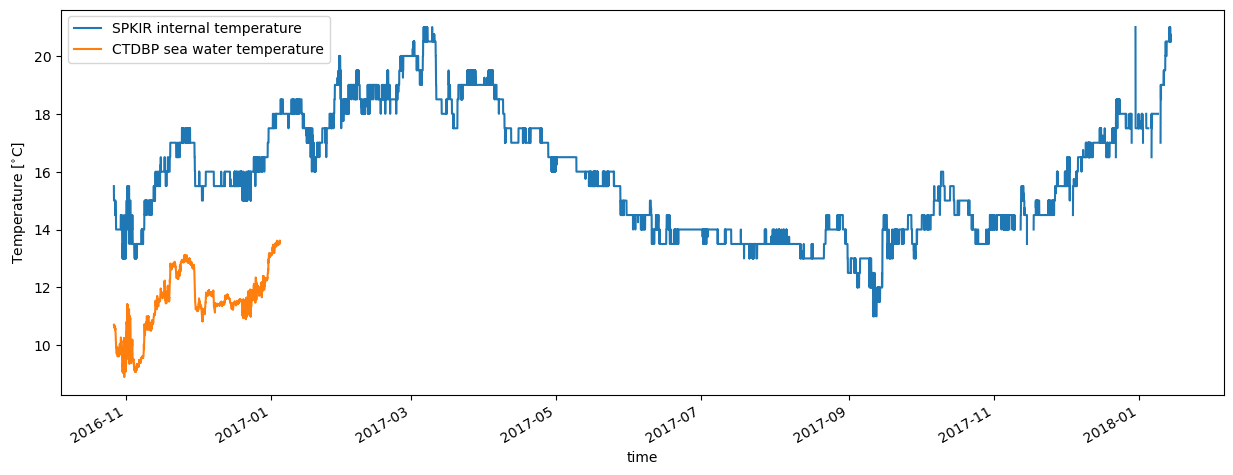

In [14]:
# Compare SPKIR internal temperature time series to sea water temperature
# to check that the instrument is performing as expected
ctdbp, fig, ax = compare_spkir_to_ctdbp(spkir, site, deploy, ctdbp_node, ctdbp_sensor)

In [23]:
# Find timestamps for temperature spikes for annotation
# Start date from 
temp_pk, _ = find_peaks(spkir.internal_temperature.sel(time=slice("2017-12-15","2018-02-01")).squeeze(), distance=12)

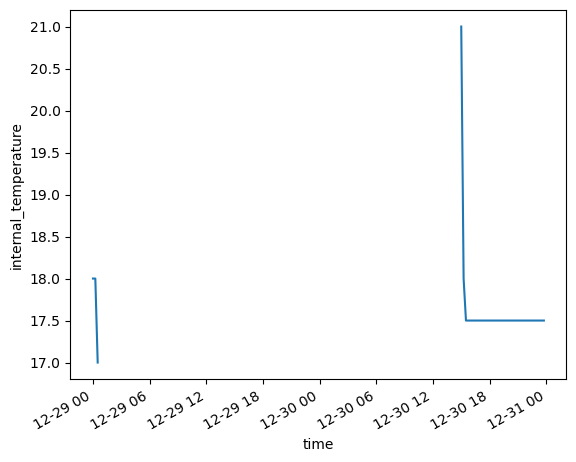

In [26]:
fig = plt.figure()
spkir.internal_temperature.sel(time=slice("2017-12-29","2017-12-30")).squeeze().plot()
# spkir.internal_temperature.sel(time=slice("2017-12-29","2017-12-30")).squeeze()[temp_pk].plot.scatter()

In [31]:
# Start annotation after last data point on 12-29
spkir.internal_temperature.where(spkir.internal_temperature.notnull(), drop=True).sel(time="2017-12-29")[-1]

<xarray.DataArray 'internal_temperature' (time: 3)>
array([18., 18., 17.], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2017-12-29 ... 2017-12-29T00:30:00
Attributes:
    coordinates:  time lon lat z

In [32]:
# End annotation after last data point
spkir.internal_temperature.squeeze()[-1]

<xarray.DataArray 'internal_temperature' ()>
array(20.5, dtype=float32)
Coordinates:
    time     datetime64[ns] 2018-01-14T10:15:00
Attributes:
    coordinates:  time lon lat z

### Histograms of downwelling irradiance measurements

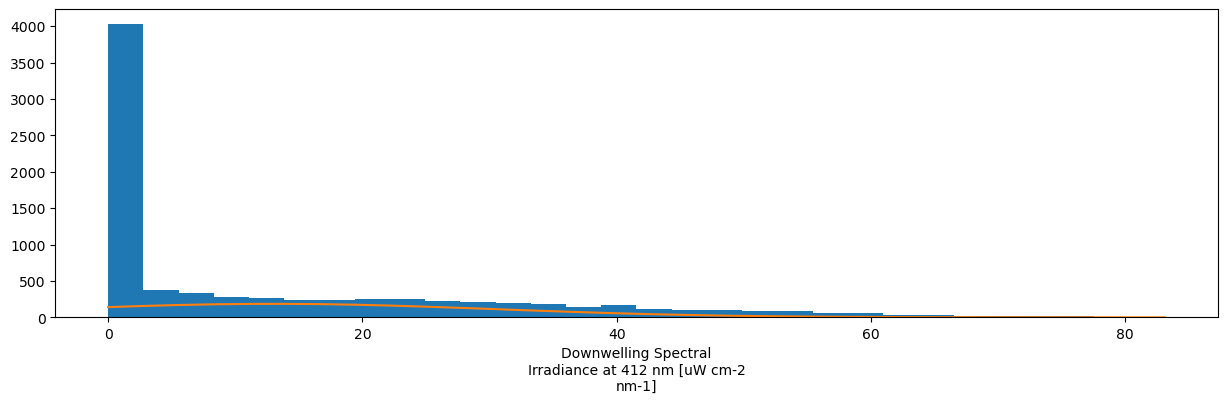

In [30]:
# histogram of downwelling irradiance @ 412 nm variable
irrad412 = spkir['downwelling_irradiance_412'][0]
# irrad412 = spkir['downwelling_irradiance_412'][0].sel(time=slice('2017-07-01'))
mu412 = irrad412.mean()
sig412 = irrad412.std()

plt.figure(figsize=(15,4))
c, x, h = irrad412.plot.hist(bins=30)
norm412 = sum(c)*norm.pdf(x, mu412, sig412)
plt.plot(x, norm412)

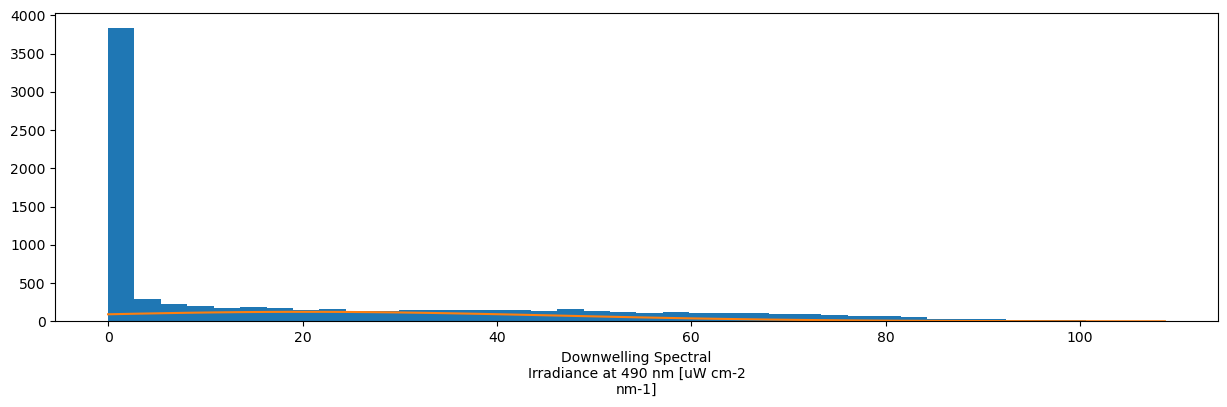

In [31]:
# histogram of downwelling irradiance @ 490 nm variable
irrad490 = spkir['downwelling_irradiance_490'][0]
# irrad490 = spkir['downwelling_irradiance_490'][0].sel(time=slice('2017-07-01'))
mu490 = irrad490.mean()
sig490 = irrad490.std()

plt.figure(figsize=(15,4))
c, x, h = irrad490.plot.hist(bins=40)
norm490 = sum(c)*norm.pdf(x, mu490, sig490)
plt.plot(x, norm490)

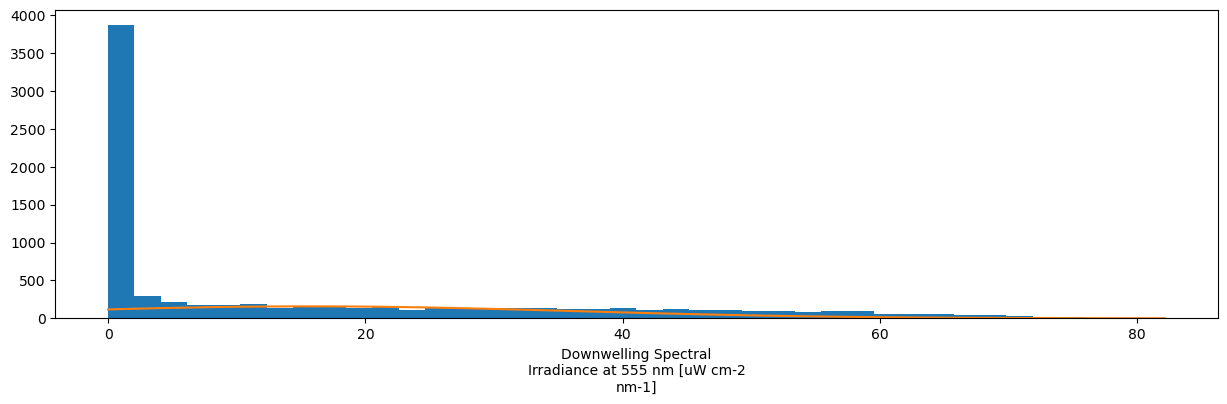

In [32]:
# histogram of downwelling irradiance @ 555 nm variable
irrad555 = spkir['downwelling_irradiance_555'][0]
# irrad555 = spkir['downwelling_irradiance_555'][0].sel(time=slice('2015-06-01'))
mu555 = irrad555.mean()
sig555 = irrad555.std()

plt.figure(figsize=(15,4))
c, x, h = irrad555.plot.hist(bins=40)
norm555 = sum(c)*norm.pdf(x, mu555, sig555)
plt.plot(x, norm555)

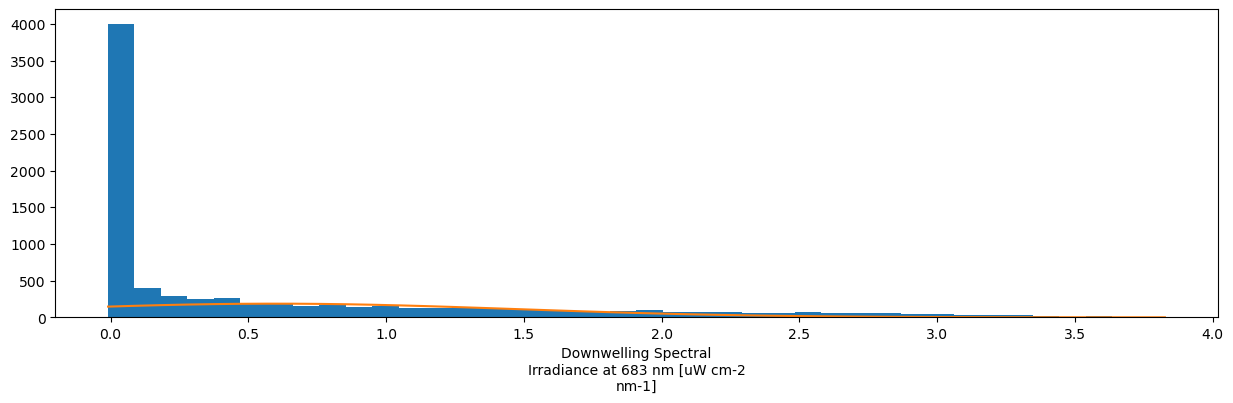

In [33]:
# histogram of downwelling irradiance @ 683 nm variable
irrad683 = spkir['downwelling_irradiance_683'][0]
# irrad683 = spkir['downwelling_irradiance_683'][0].sel(time=slice('2017-07-01'))
mu683 = irrad683.mean()
sig683 = irrad683.std()

plt.figure(figsize=(15,4))
c, x, h = irrad683.plot.hist(bins=40)
norm683 = 0.05*sum(c)*norm.pdf(x, mu683, sig683)
plt.plot(x, norm683)

In [34]:
# concat the different irradiance variables for histogram of all irradiance values
irradAll = xr.DataArray()
for var in spkir.variables:
    if "downwelling_irradiance" in var:
        irradAll = xr.concat([irradAll, spkir[var][0]], dim='channel')
irradAll

<xarray.DataArray (channel: 8, time: 8581)>
array([[            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [-1.24489265e-02, -1.22679379e-02, -1.27385072e-02, ...,
         3.33838081e+01,  2.91790657e+01,  2.71376114e+01],
       [-2.28602290e-02, -2.30053701e-02, -2.28148736e-02, ...,
         4.15520287e+01,  3.64205742e+01,  3.37744560e+01],
       ...,
       [-8.62311665e-03, -7.81955104e-03, -8.97590257e-03, ...,
         3.88252945e+01,  3.34404564e+01,  3.07892475e+01],
       [ 1.19705470e-02,  1.19244633e-02,  1.15373600e-02, ...,
         4.89614058e+00,  4.12962008e+00,  3.72692156e+00],
       [-4.96644620e-03, -5.32475766e-03, -4.51855734e-03, ...,
         1.25258076e+00,  1.05488253e+00,  9.43447709e-01]])
Coordinates:
  * time     (time) datetime64[ns] 2015-05-09T01:00:00 ... 2015-09-28T19:45:00
Dimensions without coordinates: channel

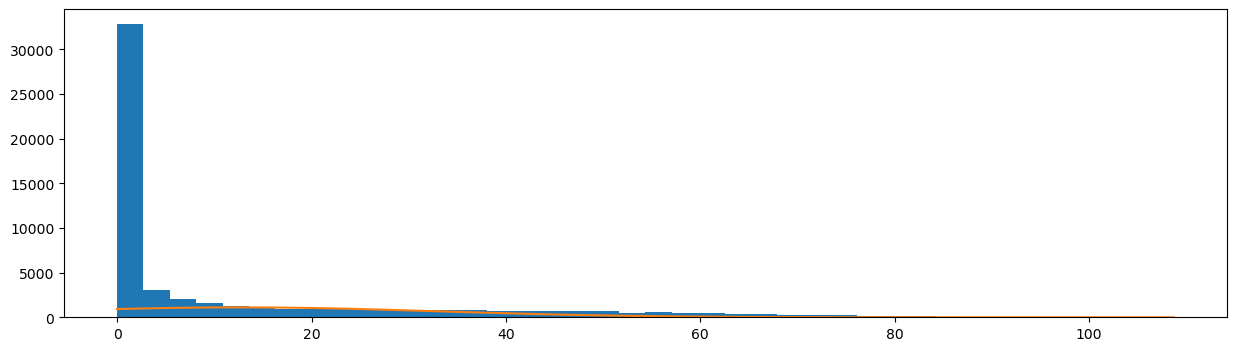

In [35]:
# histogram using all irradiance values
radAll= irradAll
muAll = radAll.mean()
sigAll = radAll.std()

plt.figure(figsize=(15,4))
c, x, h = radAll.plot.hist(bins=40)
normAll = sum(c)*norm.pdf(x, muAll, sigAll)
plt.plot(x, normAll)

### Histograms after monthly mean filter

### Spectrograms of downwelling irradiance (not burst averaged)

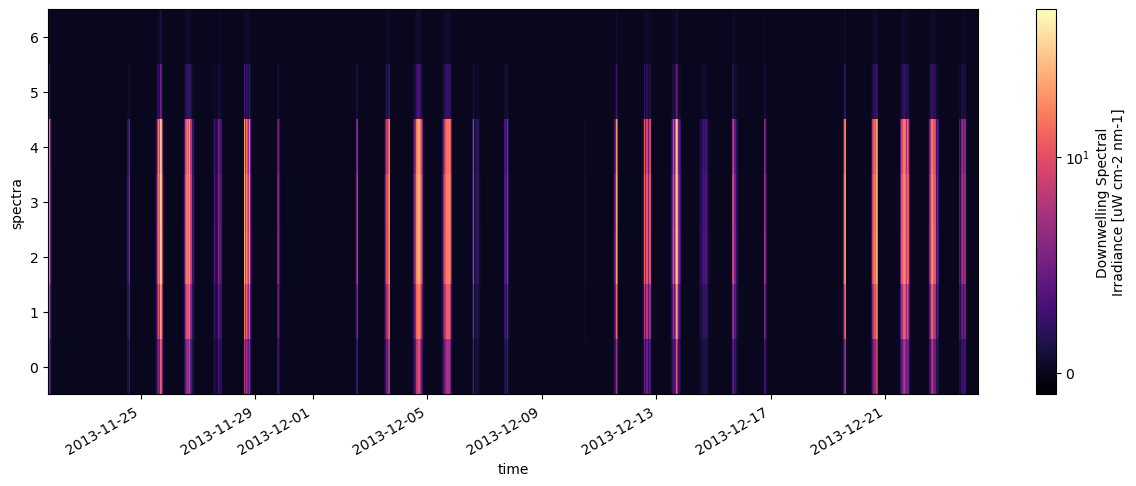

In [20]:
# Trying same plot with full resolution data with log-scale colormap (linear between -1,10)
xr.plot.pcolormesh(spkir_full_time.spkir_abj_cspp_downwelling_vector, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [28]:
# That was a bad idea so let's resample to daily
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="1D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 174, spectra: 7)>
array([[ 9.71255556e+00,  1.33028855e+01,  1.93817753e+01, ...,
         2.23164523e+01,  3.62021577e+00,  7.82912088e-01],
       [ 6.20054185e-01,  9.06080839e-01,  1.34600973e+00, ...,
         1.25914219e+00,  1.82409459e-01,  5.95385999e-02],
       [ 1.73746901e-01,  2.63608506e-01,  3.78101900e-01, ...,
         4.27118953e-01,  6.74665225e-02,  3.25888514e-02],
       ...,
       [ 7.39844170e-02,  7.86333704e-02,  8.35438973e-02, ...,
         5.61443408e-02,  8.31668786e-03,  4.77597635e-03],
       [ 2.28589437e-01,  2.76852485e-01,  3.28657073e-01, ...,
         2.09412793e-01,  2.62619446e-02,  1.17360818e-02],
       [ 2.29803754e-03,  3.92295552e-04, -2.80754229e-04, ...,
        -6.79578805e-04,  1.25565920e-03,  3.28846042e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-07 ... 2019-09-26
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

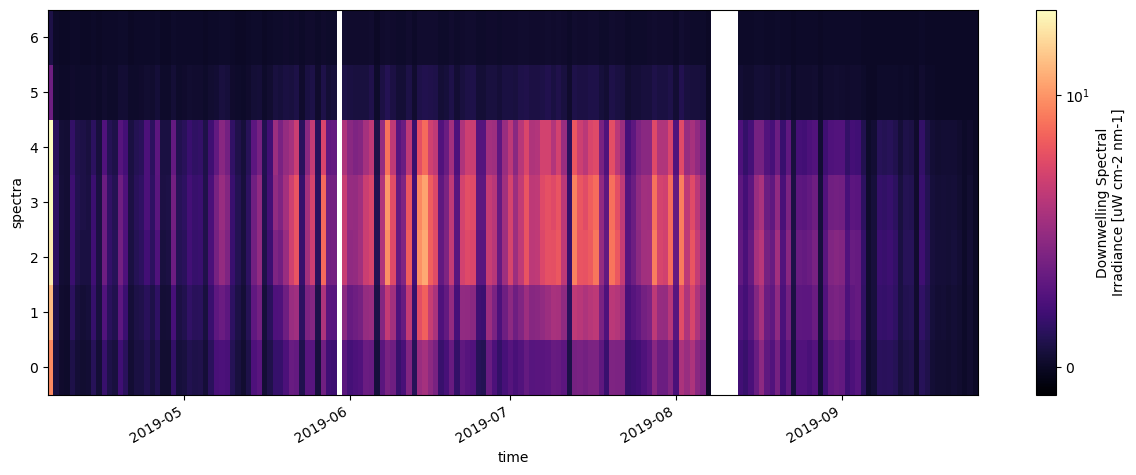

In [30]:
# pcolormesh plot with log-scale cmap except for [-1, 10] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=10, vmin=-1))

In [31]:
# Now lets try this with a 5-day median resample
downwelling_irradiance = spkir_full_time.spkir_abj_cspp_downwelling_vector
downwelling_irradiance = downwelling_irradiance.resample(time="5D").median("time")
downwelling_irradiance

<xarray.DataArray 'spkir_abj_cspp_downwelling_vector' (time: 35, spectra: 7)>
array([[6.82127204e-01, 9.39339140e-01, 1.49556243e+00, 1.66573864e+00,
        1.50775647e+00, 2.17019475e-01, 6.62599682e-02],
       [4.09351526e-01, 5.97971766e-01, 8.23282033e-01, 8.41685295e-01,
        7.24953008e-01, 1.07756459e-01, 4.46083474e-02],
       [1.11149060e+00, 1.63481436e+00, 2.06272259e+00, 1.99825457e+00,
        1.42778278e+00, 2.07900504e-01, 6.89136231e-02],
       [6.33905790e-01, 8.30168475e-01, 1.26737414e+00, 1.37036116e+00,
        1.22211412e+00, 1.81988724e-01, 5.88591173e-02],
       [4.88950510e-01, 7.05335209e-01, 1.08804481e+00, 1.18094031e+00,
        1.09429885e+00, 1.71634988e-01, 5.71144999e-02],
       [6.95715056e-01, 9.77443677e-01, 1.34453113e+00, 1.40168619e+00,
        1.25158622e+00, 1.94583331e-01, 6.10077514e-02],
       [1.77887788e+00, 2.40299210e+00, 3.25211386e+00, 3.32345650e+00,
        2.82799702e+00, 3.63398624e-01, 9.33474496e-02],
       [8.35149703e-01, 1.11870379e+00, 1.48298037e+00, 1.51192503e+00,
        1.28393037e+00, 1.92699171e-01, 5.95294177e-02],
       [1.19328147e+00, 1.70288643e+00, 2.52271664e+00, 2.78847411e+00,
        2.70395010e+00, 3.80136554e-01, 1.00454470e-01],
       [2.62830054e+00, 3.91435216e+00, 5.20132994e+00, 5.24724249e+00,
        4.42306642e+00, 5.73875815e-01, 1.45943075e-01],
...
       [2.06008457e+00, 2.58632186e+00, 3.16383481e+00, 2.98038643e+00,
        2.42941038e+00, 3.60160794e-01, 9.68550489e-02],
       [2.74753531e+00, 3.09858421e+00, 3.49182410e+00, 3.13586101e+00,
        2.39268108e+00, 3.07221372e-01, 8.25675502e-02],
       [2.20276612e+00, 2.58443371e+00, 2.88604360e+00, 2.58521177e+00,
        1.98243281e+00, 2.43159916e-01, 6.05670060e-02],
       [1.66826512e+00, 2.02154214e+00, 2.23259445e+00, 1.97611683e+00,
        1.40635816e+00, 1.69531314e-01, 4.33503864e-02],
       [2.70608963e+00, 3.34031155e+00, 3.58219552e+00, 3.11022829e+00,
        2.22732694e+00, 2.56595992e-01, 6.27982799e-02],
       [7.45937359e-01, 8.52196817e-01, 9.00792402e-01, 7.83724039e-01,
        6.10910023e-01, 8.67380087e-02, 2.31770994e-02],
       [1.05503826e+00, 1.35776975e+00, 1.46589740e+00, 1.28284831e+00,
        9.28877248e-01, 1.16683356e-01, 3.63260056e-02],
       [7.11412936e-01, 9.11214792e-01, 1.05646410e+00, 9.39103459e-01,
        7.16780233e-01, 8.74880143e-02, 2.91914385e-02],
       [3.15291575e-01, 3.98664721e-01, 4.91061523e-01, 4.47583359e-01,
        3.45641780e-01, 4.67864891e-02, 1.80901622e-02],
       [6.95465087e-03, 5.62515071e-03, 3.77377740e-03, 2.68314116e-03,
        3.17550394e-03, 3.19469816e-03, 4.37195968e-03]])
Coordinates:
  * spectra  (spectra) int32 0 1 2 3 4 5 6
  * time     (time) datetime64[ns] 2019-04-06 2019-04-11 ... 2019-09-23
Attributes:
    _FillValue:               -9999999.0
    comment:                  Downwelling Spectral Irradiance is the measure ...
    long_name:                Downwelling Spectral Irradiance
    precision:                4
    coordinates:              time lat lon
    data_product_identifier:  SPECTIR_L1
    units:                    uW cm-2 nm-1
    ancillary_variables:      channel_array

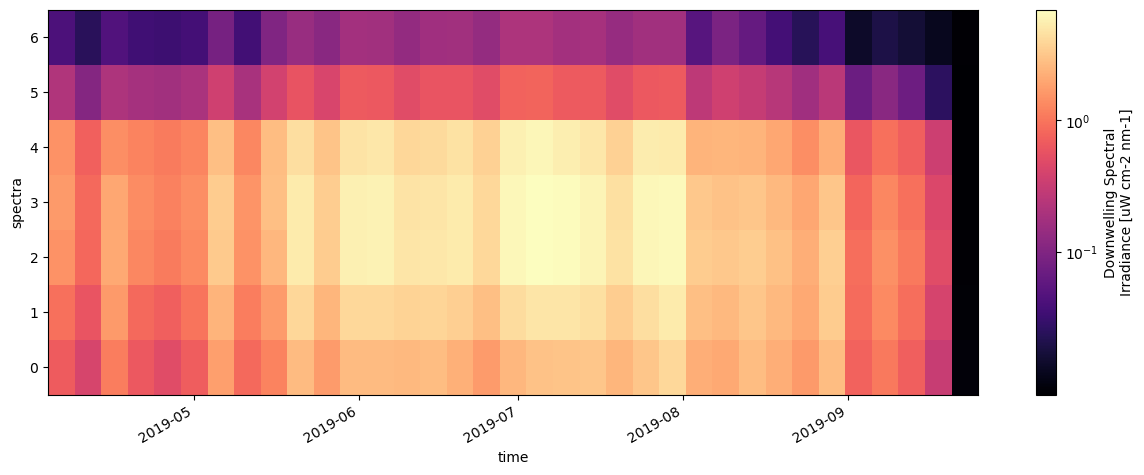

In [37]:
# 5-day median of downwelling spectral irradiance pcolormesh plot with log-scale cmap except for [0, 0.01] which is linear
xr.plot.pcolormesh(downwelling_irradiance, x="time", y="spectra", cmap='magma', figsize=(15,5), norm=colors.SymLogNorm(linthresh=0.1))